In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# 异常值处理，使用KNN填充球速缺失值

In [3]:
df = pd.read_csv('Wimbledon_featured_matches.csv', na_values='NA')
df.head

<bound method NDFrame.head of                  match_id         player1         player2 elapsed_time  \
0     2023-wimbledon-1301  Carlos Alcaraz   Nicolas Jarry     00:00:00   
1     2023-wimbledon-1301  Carlos Alcaraz   Nicolas Jarry     00:00:38   
2     2023-wimbledon-1301  Carlos Alcaraz   Nicolas Jarry     00:01:01   
3     2023-wimbledon-1301  Carlos Alcaraz   Nicolas Jarry     00:01:31   
4     2023-wimbledon-1301  Carlos Alcaraz   Nicolas Jarry     00:02:21   
...                   ...             ...             ...          ...   
7279  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     04:39:58   
7280  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     04:40:43   
7281  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     04:41:20   
7282  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     04:41:52   
7283  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     04:42:27   

      set_no  game_no  point_no  p1_sets  p2_sets  p1_games  ...  \
0          1 

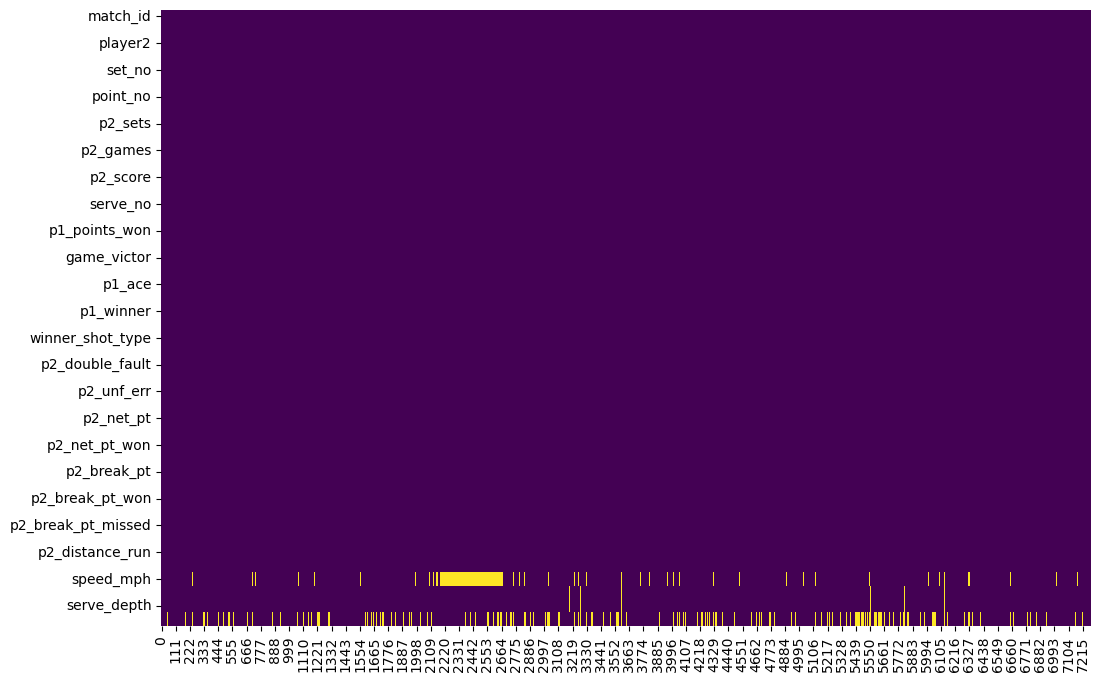

In [4]:
plt.figure(figsize=(12,8))
sns.heatmap(df.transpose().isnull(), cbar=False, cmap='viridis')
plt.show()

In [5]:
df['hitter'] = df.apply(lambda row: row['player1'] if row['server'] == 1 else row['player2'], axis=1)

In [6]:
# 使用KNN填充缺失值
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder

# 准备数据：选择用于确定相似性的字段
features_for_imputation = ['hitter', 'serve_width', 'serve_depth', 'return_depth', 'winner_shot_type']
data_for_imputation = df[features_for_imputation].copy()

# 数值化分类变量
# 数值化分类变量
for column in features_for_imputation:
    if data_for_imputation[column].dtype == 'object':
        # 为每个分类变量创建一个新的LabelEncoder实例
        le = LabelEncoder()
        # 使用LabelEncoder转换分类变量，先填充缺失值然后进行转换
        data_for_imputation[column] = le.fit_transform(data_for_imputation[column].fillna('Unknown'))

# 添加speed_mph到用于填充的数据集
data_for_imputation['speed_mph'] = df['speed_mph']

# 分离出有speed_mph值的数据和无speed_mph值的数据
data_with_speed = data_for_imputation.dropna(subset=['speed_mph'])
data_without_speed = data_for_imputation[data_for_imputation['speed_mph'].isnull()]

# 由于数据集可能很大，我们使用一个小的子集来加速这个过程
data_with_speed_sample = data_with_speed.sample(n=min(1000, len(data_with_speed)), random_state=42)

# 使用KNeighborsRegressor来填充speed_mph
knn = KNeighborsRegressor(n_neighbors=1)

# 训练模型
knn.fit(data_with_speed_sample[features_for_imputation], data_with_speed_sample['speed_mph'])

# 对缺失speed_mph的观测进行预测填充
if not data_without_speed.empty:
    predicted_speeds = knn.predict(data_without_speed[features_for_imputation])
    df.loc[data_without_speed.index, 'speed_mph'] = predicted_speeds

# 检查是否还有缺失值
df['speed_mph'].isnull().sum()

0

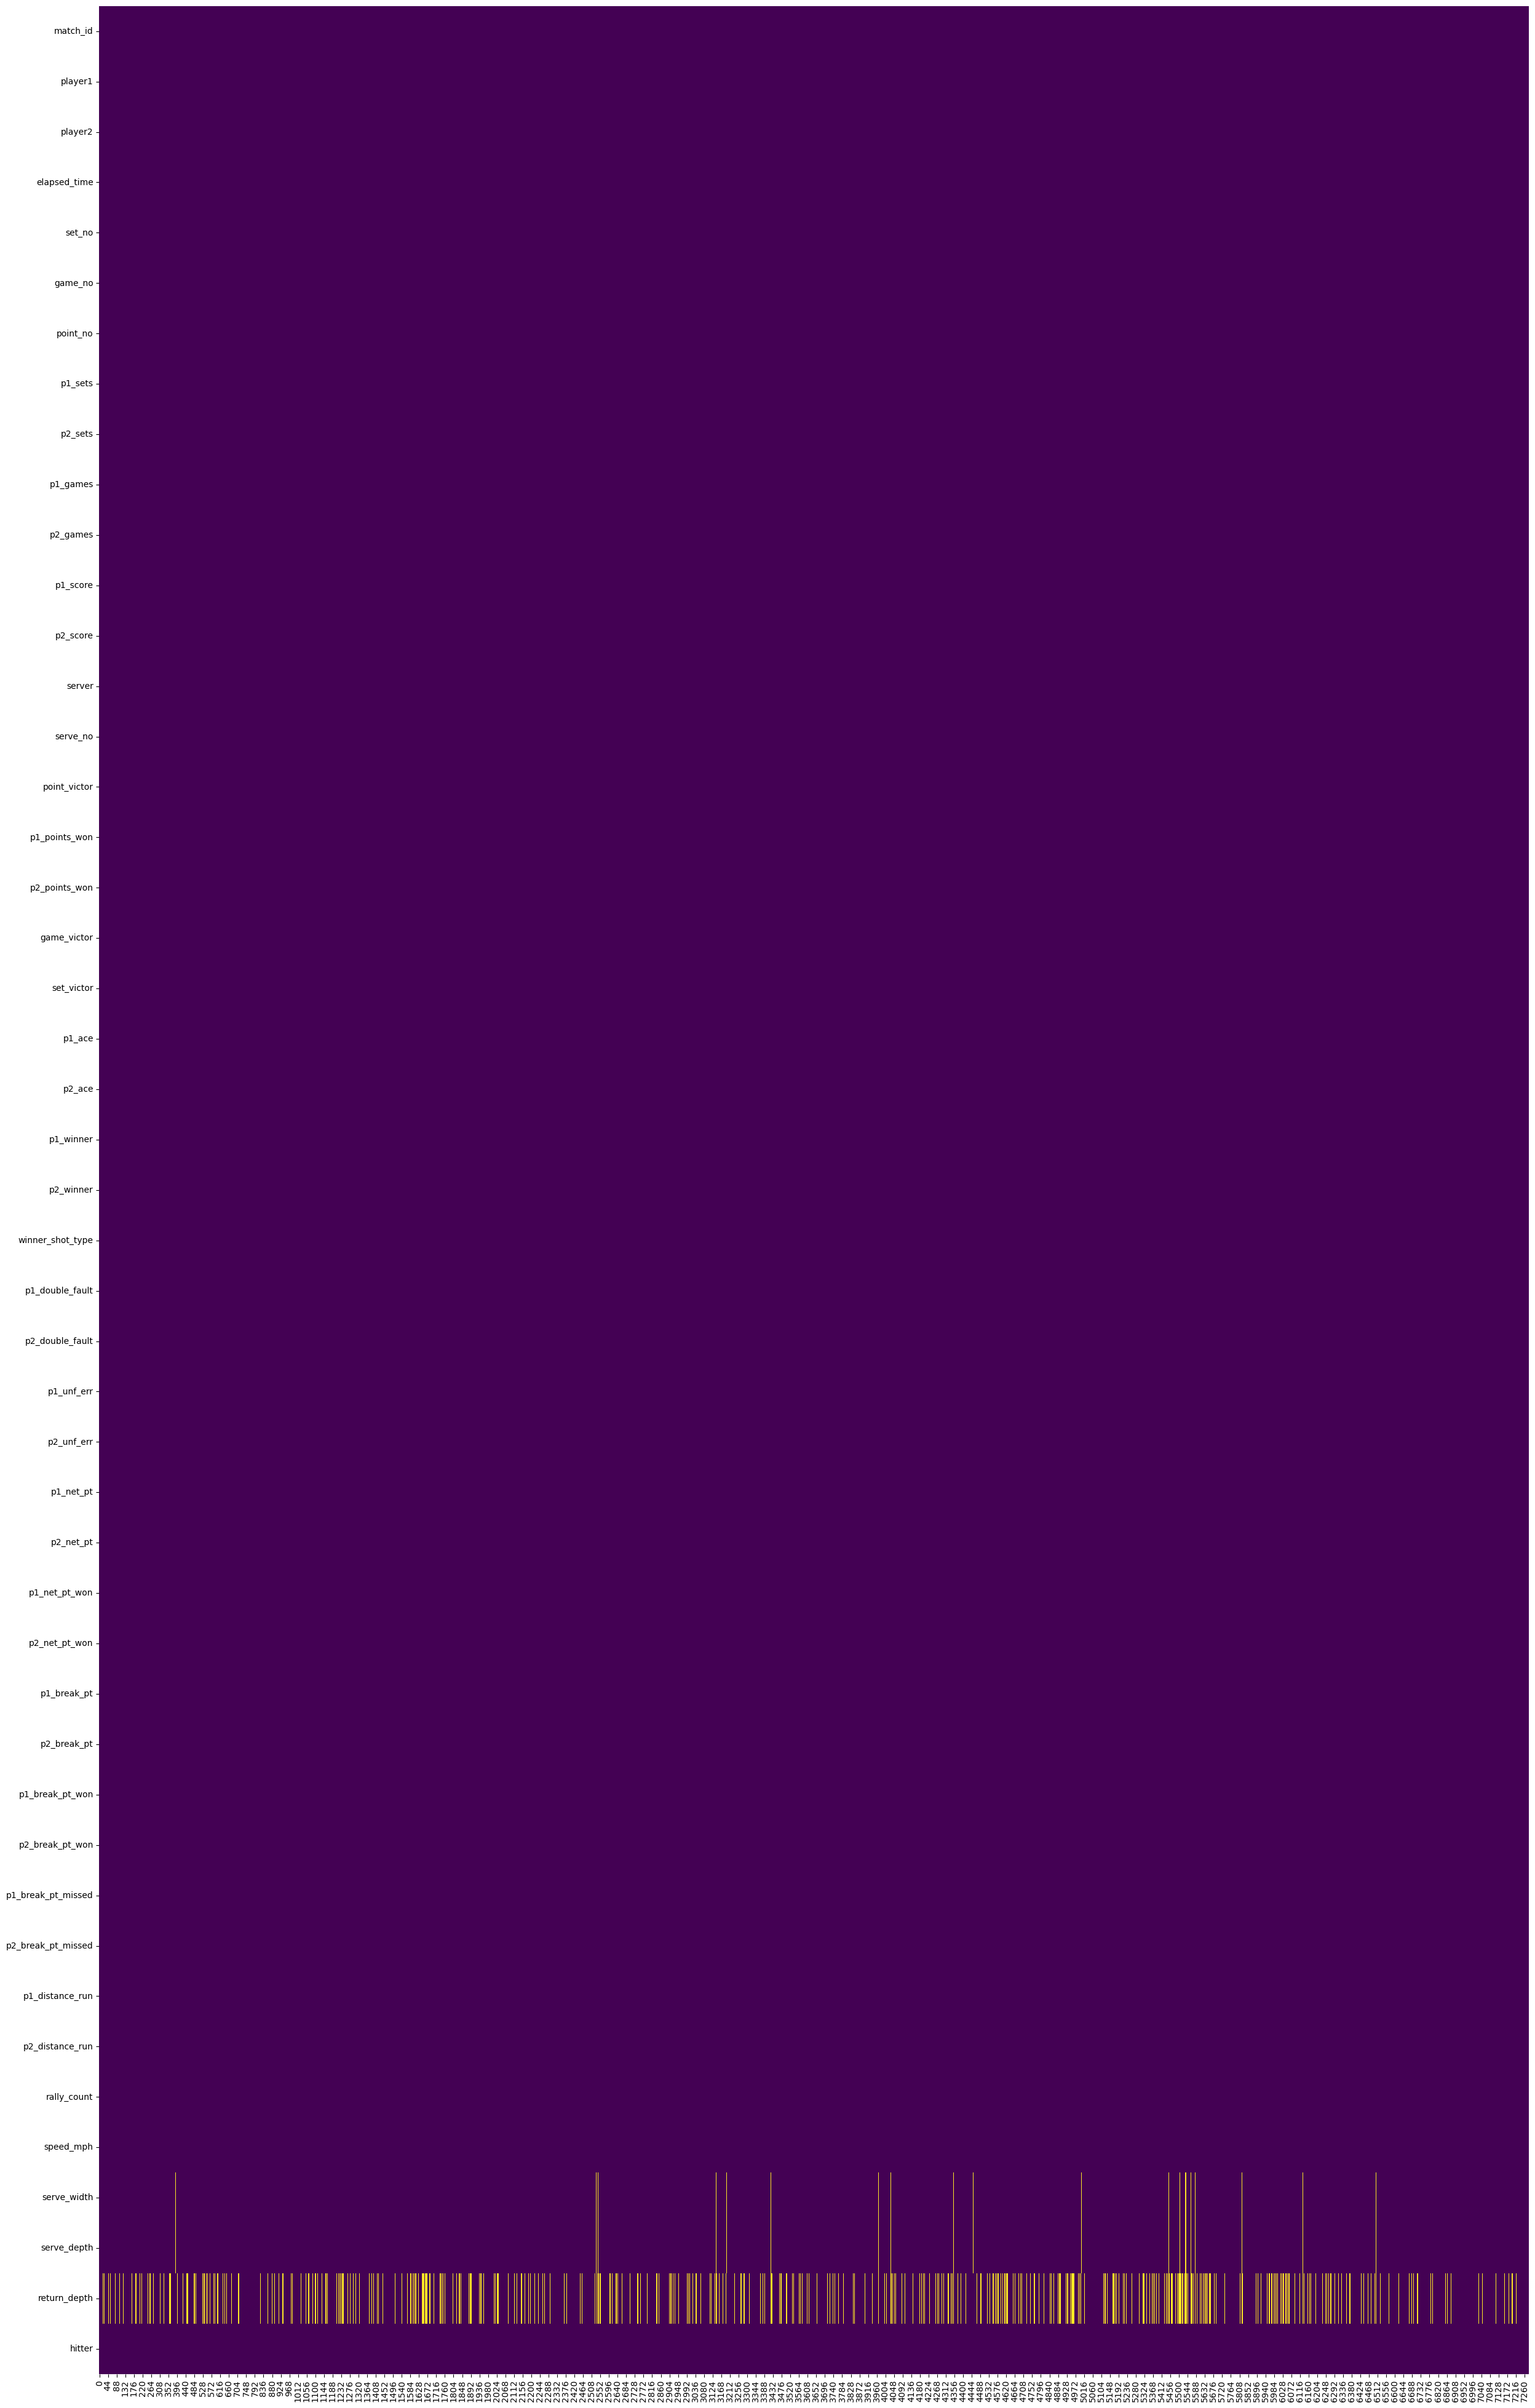

In [7]:
plt.figure(figsize=(30,50))
sns.heatmap(df.transpose().isnull(), cbar=False, cmap='viridis')
plt.show()

# Feature Generation

In [8]:
# 获取运动员列表
players = pd.unique(df[['player1', 'player2']].values.ravel('K'))
print(players)

['Carlos Alcaraz' 'Alexander Zverev' 'Frances Tiafoe'
 'Alejandro Davidovich Fokina' 'Daniil Medvedev' 'Jiri Lehecka'
 'Christopher Eubanks' 'Laslo Djere' 'Jannik Sinner' 'Daniel Elahi Galan'
 'Guido Pella' 'Denis Shapovalov' 'Andrey Rublev' 'Alexander Bublik'
 'Lorenzo Musetti' 'Stan Wawrinka' 'Grigor Dimitrov' 'Roman Safiullin'
 'Hubert Hurkacz' 'Nicolas Jarry' 'Matteo Berrettini' 'Holger Rune'
 'Marton Fucsovics' 'Tommy Paul' "Christopher O'Connell"
 'Stefanos Tsitsipas' 'Quentin Halys' 'Mikael Ymer' 'Liam Broady'
 'David Goffin' 'Maximilian Marterer' 'Novak Djokovic']


In [10]:
# 首先，创建一个空的DataFrame来存储特征
features_df = pd.DataFrame()

grouped = df.groupby('match_id')

dataframes = {}
for name, group in grouped:
    # 对于每个运动员，我们将遍历df来确定他们的特征
    player12 = [group.iloc[0]['player1'], group.iloc[0]['player2']]
    
    for player in player12:
        player_df = group.apply(lambda row: pd.Series({
            'player': player,
            'match_id': row['match_id'],
            'set_no': row['set_no'],
            'game_no': row['game_no'],
            'point_no': row['point_no'],
            'elapsed_time': row['elapsed_time'],
            'p1_score': row['p1_score'],
            'p2_score': row['p2_score'],
            
            'y': int(row['point_victor'] == (1 if row['player1'] == player else 2)),
            'if_score': int(row['point_victor'] == (1 if row['player1'] == player else 2)),
            'if_nscore': int(row['point_victor'] != (1 if row['player1'] == player else 2)),
            'if_server': int(row['server'] == (1 if row['player1'] == player else 2)),
            'if_win_game': int(row['game_victor'] == (1 if row['player1'] == player else 2)),
            'if_win_set': int(row['set_victor'] == (1 if row['player1'] == player else 2)),

            'game_point': 1 if (((row['p1_score'] == '40' and row['p2_score'] in ['0', '15', '30']) or (row['p1_score'] == 'AD' and row['p2_score'] == '40')) and row['player1'] == player) or (((row['p2_score'] == '40' and row['p1_score'] in ['0', '15', '30']) or (row['p2_score'] == 'AD' and row['p1_score'] == '40')) and row['player2'] == player) else 0,
            'break_point':1 if (row['p1_break_pt'] == 1 and row['player1'] == player) or (row['p2_break_pt'] == 1 and row['player2'] == player) else 0,
            'break_fail':1 if (row['p1_break_pt_missed'] == 1 and row['player1'] == player) or (row['p2_break_pt_missed'] == 1 and row['player2'] == player) else 0,
            'broken':1 if (row['p1_break_pt_won'] == 1 and row['player2'] == player) or (row['p2_break_pt_won'] == 1 and row['player1'] == player) else 0,
            'rally_count': row['rally_count'],
            
            'speed_mph': row['speed_mph'],
            'net_pt':1 if (row['p1_net_pt'] == 1 and row['player1'] == player) or (row['p2_net_pt'] == 1 and row['player2'] == player) else 0,
            'serve_width': row['serve_width'],
            'serve_depth': row['serve_depth'],
            'return_depth': row['return_depth'],
            }), axis=1)
        features_df = pd.concat([features_df, player_df], ignore_index=True)

features_df.sort_values(by=['player', 'match_id', 'set_no', 'game_no', 'point_no'], inplace=True)  # inplace=True表示在原数据上进行排序
features_df.head(10)

,player,match_id,set_no,game_no,point_no,elapsed_time,p1_score,p2_score,y,if_score,...,game_point,break_point,break_fail,broken,rally_count,speed_mph,net_pt,serve_width,serve_depth,return_depth
1270,Alejandro Davidovich Fokina,2023-wimbledon-1304,1,1,1,00:00:00,0,0,1,1,...,0,0,0,0,1,86.0,0,B,NCTL,D
1271,Alejandro Davidovich Fokina,2023-wimbledon-1304,1,1,2,00:00:41,15,0,1,1,...,0,0,0,0,1,92.0,0,B,NCTL,D
1272,Alejandro Davidovich Fokina,2023-wimbledon-1304,1,1,3,00:01:09,30,0,1,1,...,0,0,0,0,1,102.0,0,W,CTL,ND
1273,Alejandro Davidovich Fokina,2023-wimbledon-1304,1,1,4,00:01:29,40,0,1,1,...,1,0,0,0,1,120.0,0,BW,CTL,ND
1274,Alejandro Davidovich Fokina,2023-wimbledon-1304,1,2,5,00:02:42,0,0,0,0,...,0,0,0,0,1,112.0,0,BW,NCTL,NaN
1275,Alejandro Davidovich Fokina,2023-wimbledon-1304,1,2,6,00:03:10,0,15,0,0,...,0,0,0,0,3,123.0,0,C,NCTL,ND
1276,Alejandro Davidovich Fokina,2023-wimbledon-1304,1,2,7,00:03:49,0,30,0,0,...,0,0,0,0,3,123.0,0,W,CTL,D
1277,Alejandro Davidovich Fokina,2023-wimbledon-1304,1,2,8,00:04:13,0,40,0,0,...,0,0,0,0,3,104.0,0,W,NCTL,ND
1278,Alejandro Davidovich Fokina,2023-wimbledon-1304,1,3,9,00:04:57,0,0,1,1,...,0,0,0,0,1,100.0,0,BC,NCTL,D
1279,Alejandro Davidovich Fokina,2023-wimbledon-1304,1,3,10,00:05:29,15,0,1,1,...,0,0,0,0,1,114.0,0,C,NCTL,ND


In [33]:
features_df.to_csv('features.csv', index=False)

# 使用决策树，对球的客观质量进行打分（暂时没用）

In [10]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
le = LabelEncoder()

# Replace letter encoding with numeric encoding for serve_width, serve_depth, and return_depth columns
features_df['serve_width'] = le.fit_transform(features_df['serve_width'])
dict_sw = dict(zip(range(len(le.classes_)), le.classes_))
print(dict(zip(range(len(le.classes_)), le.classes_)))

features_df['serve_depth'] = le.fit_transform(features_df['serve_depth'])
dict_sd = dict(zip(range(len(le.classes_)), le.classes_))
print(dict(zip(range(len(le.classes_)), le.classes_)))

features_df['return_depth'] = le.fit_transform(features_df['return_depth'])
dict_rd = dict(zip(range(len(le.classes_)), le.classes_))
print(dict(zip(range(len(le.classes_)), le.classes_)))

features_df['player'] = le.fit_transform(features_df['player'])
dict_player = dict(zip(range(len(le.classes_)), le.classes_))
print(dict(zip(range(len(le.classes_)), le.classes_)))

eval_serve = features_df[features_df['if_server'] == 1][['y', 'player', 'if_server', 'speed_mph', 'net_pt', 'serve_width', 'serve_depth', 'return_depth']]
eval_return = features_df[features_df['if_server'] == 0][['y', 'player', 'if_server', 'speed_mph', 'net_pt', 'serve_width', 'serve_depth', 'return_depth']]

{0: 'B', 1: 'BC', 2: 'BW', 3: 'C', 4: 'W', 5: nan}
{0: 'CTL', 1: 'NCTL', 2: nan}
{0: 'D', 1: 'ND', 2: nan}
{0: 'Alejandro Davidovich Fokina', 1: 'Alexander Bublik', 2: 'Alexander Zverev', 3: 'Andrey Rublev', 4: 'Carlos Alcaraz', 5: 'Christopher Eubanks', 6: "Christopher O'Connell", 7: 'Daniel Elahi Galan', 8: 'Daniil Medvedev', 9: 'David Goffin', 10: 'Denis Shapovalov', 11: 'Frances Tiafoe', 12: 'Grigor Dimitrov', 13: 'Guido Pella', 14: 'Holger Rune', 15: 'Hubert Hurkacz', 16: 'Jannik Sinner', 17: 'Jiri Lehecka', 18: 'Laslo Djere', 19: 'Liam Broady', 20: 'Lorenzo Musetti', 21: 'Marton Fucsovics', 22: 'Matteo Berrettini', 23: 'Maximilian Marterer', 24: 'Mikael Ymer', 25: 'Nicolas Jarry', 26: 'Novak Djokovic', 27: 'Quentin Halys', 28: 'Roman Safiullin', 29: 'Stan Wawrinka', 30: 'Stefanos Tsitsipas', 31: 'Tommy Paul'}


In [11]:
eval_serve.head(10)

,y,player,if_server,speed_mph,net_pt,serve_width,serve_depth,return_depth
1270,1,0,1,86.0,0,0,1,0
1271,1,0,1,92.0,0,0,1,0
1272,1,0,1,102.0,0,4,0,1
1273,1,0,1,120.0,0,2,0,1
1278,1,0,1,100.0,0,1,1,0
1279,1,0,1,114.0,0,3,1,1
1280,1,0,1,95.0,0,1,1,0
1281,1,0,1,117.0,1,4,1,0
1292,1,0,1,97.0,0,4,1,0
1293,1,0,1,104.0,0,3,0,0


In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
# Split the eval_serve dataframe into features (X) and the target variable (y)
X = eval_serve[['player','speed_mph', 'serve_width', 'serve_depth', 'return_depth']]
y = eval_serve['y']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create an instance of the DecisionTreeClassifier
clf_serve = DecisionTreeClassifier()

# Fit the decision tree model to the training data
clf_serve.fit(X_train, y_train)

# Predict the probabilities of event y=1 for the testing data
y_pred_proba = clf_serve.predict_proba(X_test)[:, 1]

# Print the predicted probabilities
print(y_pred_proba)


[1.   1.   1.   ... 0.25 0.5  0.  ]


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict the classes of the testing data
y_pred = clf_serve.predict(X_test)

# Calculate the accuracy, precision, recall and f1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.5928636779505947
Precision: 0.6885593220338984
Recall: 0.6846910112359551
F1 Score: 0.6866197183098591


In [22]:
# 这段代码可以根据特定的特征值预测发球得分概率！
features = {'player':9, 'speed_mph': 112, 'serve_width': 2, 'serve_depth': 1, 'return_depth': 0}

# Convert the features to DataFrame
features_df = pd.DataFrame([features])

# Predict the probabilities
probabilities = clf_serve.predict_proba(features_df)[:, 1]

print(probabilities)

[1.]


In [42]:
# Split the eval_serve dataframe into features (X) and the target variable (y)
X = eval_return[['player', 'speed_mph', 'net_pt', 'serve_width', 'serve_depth', 'return_depth']]
y = eval_return['y']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an instance of the DecisionTreeClassifier
clf_return = DecisionTreeClassifier()

# Fit the decision tree model to the training data
clf_return.fit(X_train, y_train)

# Predict the probabilities of event y=1 for the testing data
y_pred_proba = clf_return.predict_proba(X_test)[:, 1]

# Print the predicted probabilities
print(y_pred_proba)


[1. 1. 0. ... 1. 0. 1.]


In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict the classes of the testing data
y_pred = clf_return.predict(X_test)

# Calculate the accuracy, precision, recall and f1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.6218256691832532
Precision: 0.4375
Recall: 0.38028169014084506
F1 Score: 0.40688912809472555


In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=0)

# Train the classifier
clf.fit(X_train, y_train)

# Predict the classes of the testing data
y_pred = clf.predict(X_test)

# Calculate the accuracy, precision, recall and f1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.636238846945779
Precision: 0.4566929133858268
Recall: 0.3501006036217304
F1 Score: 0.39635535307517084


# 准备用于LASSO的数据

In [ ]:
# 确定需要求和的列
if_columns = ['if_score', 'if_nscore', 'if_win_game', 'if_win_set','game_point','break_point', 'break_fail', 'broken','rally_count']
player_dfs = {}
r = 0.9

for player, player_df in features_df.groupby('player'):
    # 创建原 DataFrame 的副本以避免直接修改原数据
    player_df_copy = player_df.copy()
    
    for match_id, group in player_df.groupby('match_id'):
        # 获取当前分组的索引
        idx = group.index
        
        for col in if_columns:
            # 在 player_df_copy 上为每个 if_column 创建加权和列
            player_df_copy.loc[idx, f'weighted_sum_{col}'] = 0
            
            for i in range(1, len(idx)):
                weights = r ** np.arange(i)[::-1]  # 生成权重
                weighted_sum = np.sum(group[col].iloc[:i] * weights)
                
                # 直接在 player_df_copy 上更新加权和的值
                player_df_copy.at[idx[i], f'weighted_sum_{col}'] = weighted_sum

    player_dfs[player] = player_df_copy

# 选择一个示例 player 的 DataFrame 并打印前几行
print(player_dfs['Roman Safiullin'].head(10))

In [ ]:
for player, player_df in player_dfs.items():
    player_df.to_csv(player + '.csv', index=False)